# Visualizing UN Population Projections

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import matplotlib.colors as colors, matplotlib.colorbar as colorbar 
import matplotlib.cm as cm, matplotlib.font_manager as fm
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [2]:
# define the fonts to use for plots
family = 'Myriad Pro'
title_font = fm.FontProperties(family=family, style='normal', size=24, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=18, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
annot_font = fm.FontProperties(family=family, style='normal', size=12, weight='normal', stretch='normal')

In [3]:
def get_colors(cmap, n, start=0., stop=1., alpha=1., reverse=False):
    '''return n-length list of rgba colors from the passed colormap name and alpha,
       limit extent by start/stop values and reverse list order if flag is true'''
    import matplotlib.cm as cm, numpy as np
    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return list(reversed(colors)) if reverse else colors

## First, prep the data set

The World Population Prospects dataset, 2015 revision, is by the UN Department of Social and Economic Affairs, Population Division: http://esa.un.org/unpd/wpp/DVD/. See here for more info on [ISO country codes](https://en.wikipedia.org/wiki/ISO_3166-1_numeric).

I'll look at the UN's "medium variant" projections. For even wilder numbers, you can examine the "constant fertility" projections.

In [4]:
# choose which UN population prediction to use (ie, which tab in the excel file)
variant = 'MEDIUM VARIANT'

In [5]:
# load the population projections data and rename wonky column names
df_excel = pd.read_excel('data/WPP2015_POP_F01_1_TOTAL_POPULATION_BOTH_SEXES.XLS',
                         sheetname=variant, skiprows=range(16))
df_excel = df_excel.rename(columns={'Country code':'country_code', 'Major area, region, country or area *':'country_name'})

In [6]:
# load the ISO UN country codes and prepend zeros
country_codes = pd.read_csv('data/country_names_codes.csv', encoding='utf-8')
country_codes['country_code'] = country_codes['country_code'].astype(str).str.zfill(3)

In [7]:
# filter the excel data set by only those rows that appear in the list of country codes
# this filters out continent and regional scale entities
df_excel['country_code'] = df_excel['country_code'].astype(unicode).str.zfill(3)
df_full = df_excel[df_excel['country_code'].isin(country_codes['country_code'])].copy()

In [8]:
# retain only a subset of columns
cols = ['country_name', 'country_code', '2015', '2020', '2030', '2040', '2050', '2060', '2070', '2080', '2090', '2100']
df = df_full[cols].copy()

In [9]:
# clean up a couple of country names
df['country_name'] = df['country_name'].str.replace('United States of America', 'USA')
df['country_name'] = df['country_name'].str.replace('Russian Federation', 'Russia')
df['country_name'] = df['country_name'].str.replace('Democratic Republic of the Congo', 'Congo')
df['country_name'] = df['country_name'].str.replace('United Republic of Tanzania', 'Tanzania')
df['country_name'] = df['country_name'].str.replace('Other non-specified areas', 'Taiwan')

In [10]:
# multiply all numeric columns by 1000 to get population in units of 1 instead of 1000
f = lambda x: x if isinstance(x, basestring) else x * 1000
df = df.applymap(f)

In [11]:
# select the countries in africa for further analysis
africa = df.iloc[0:58]

# then sort df by current pop and reset index
df = df.sort_values(by='2015', ascending=True, inplace=False)
df = df.reset_index(drop=True)
df.head()

,country_name,country_code,2015,2020,2030,2040,2050,2060,2070,2080,2090,2100
0,Holy See,336,800.0,804.0,805.0,814.0,824.0,838.0,835.0,830.0,825.0,825.0
1,Tokelau,772,1250.0,1357.0,1449.0,1503.0,1568.0,1624.0,1632.0,1622.0,1580.0,1514.0
2,Niue,570,1610.0,1621.0,1662.0,1725.0,1767.0,1803.0,1818.0,1797.0,1765.0,1721.0
3,Falkland Islands (Malvinas),238,2903.0,2932.0,2935.0,2901.0,2866.0,2817.0,2761.0,2727.0,2693.0,2653.0
4,Saint Helena,654,3961.0,4052.0,4224.0,4218.0,4107.0,4004.0,3901.0,3788.0,3619.0,3435.0


## Next, examine the continent/supernational scale data

In [12]:
# extract the supernational regions, they are in upper-case
df_regions = df_excel[df_excel['country_name']==df_excel['country_name'].str.upper()]
df_regions = df_regions[cols].copy()
df_regions = df_regions.applymap(f)

In [13]:
df_regions = df_regions.drop(labels=0, axis=0)
df_regions['country_name'] = df_regions['country_name'].str.title()
df_regions.loc[187, 'country_name'] = 'Latin America'

In [14]:
# first re-index by area name for one line per country
df_plot = df_regions.copy()
df_plot.index = df_plot['country_name']
df_plot = df_plot.drop(['country_name'], axis=1)
df_plot = df_plot.transpose()
df_plot = df_plot.drop('country_code', axis=0)

In [15]:
color_list = get_colors('spectral', n=len(df_regions), start=0.1, stop=0.95, reverse=True)

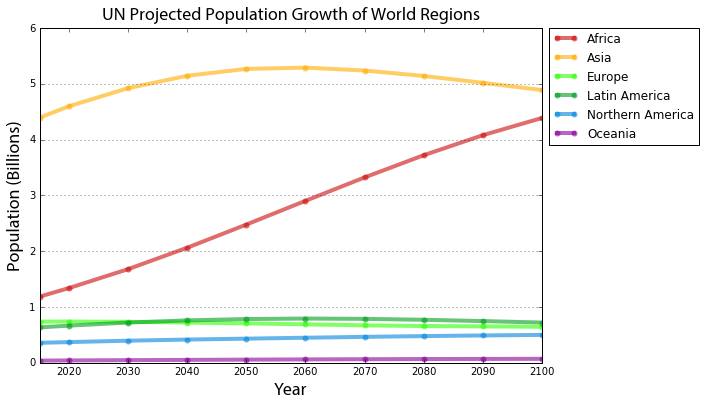

In [16]:
fig, ax = plt.subplots(figsize=[9, 6])
lines = []
for col, c in zip(df_plot.columns, color_list):
    ax.plot(df_plot[col]/10**9, linewidth=4, alpha=0.6, marker='o', markeredgewidth=0, color=c)
    lines.append(col)
    
ax.set_title('UN Projected Population Growth of World Regions', fontproperties=label_font, y=1.01)
ax.set_xlabel('Year', fontproperties=label_font)
ax.set_ylabel('Population (Billions)', fontproperties=label_font)
ax.yaxis.grid()
ax.set_axis_bgcolor('#ffffff')
ax.set_xlim([2015, 2100])
ax.legend(lines, loc='center right', bbox_to_anchor=(1.325,0.825))

fig.savefig('images/projected-pop-line-regions.png', dpi=96)
plt.show()

## Now, plot population change as a line chart

In [17]:
# first re-index by area name for one line per country
df_plot = df.copy()
df_plot.index = df_plot['country_name']
df_plot = df_plot.drop(['country_name'], axis=1)

# only keep countries that exceed some minimum population threshold, and transpose df for line plotting
min_population = 10 * 10**6
df_plot = df_plot[df_plot['2015'] > min_population]
df_plot = df_plot.transpose()
df_plot = df_plot.drop('country_code', axis=0)

In [18]:
# get one color for each country's line
color_list = get_colors('spectral', n=len(df_plot.columns), start=0.05, stop=0.9)

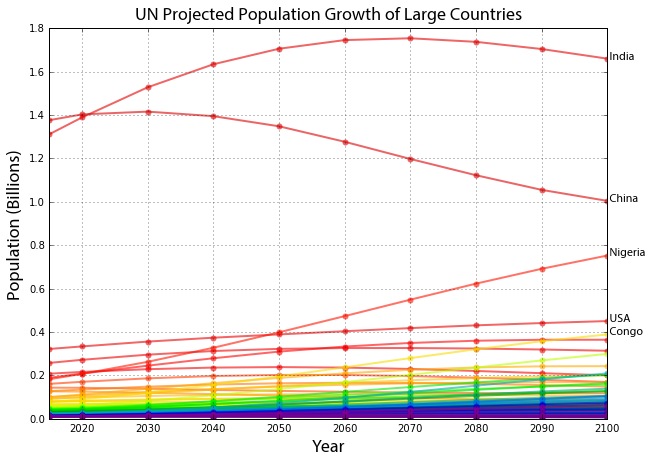

In [19]:
fig, ax = plt.subplots(figsize=[10, 7])
for col, c in reversed(zip(df_plot.columns, color_list)):
    ax.plot(df_plot[col]/10**9, linewidth=2, alpha=0.6, marker='o', markeredgewidth=0, color=c)
    
ax.set_title('UN Projected Population Growth of Large Countries', fontproperties=label_font, y=1.01)
ax.set_xlabel('Year', fontproperties=label_font)
ax.set_ylabel('Population (Billions)', fontproperties=label_font)
ax.grid()
ax.set_axis_bgcolor('#ffffff')
ax.set_xlim([2015, 2100])

# annotate the top 5 countries
def annotate(row):
    bbox = dict(boxstyle='round', color='w', fc='w', alpha=0.0)
    name = ' {}'.format(row['country_name'])
    pop = row['2100'] / 10**9
    ax.annotate(name, xy=(2100, pop), bbox=bbox, xycoords='data', fontproperties=annot_font)
df.sort_values(by='2100', ascending=False).head().apply(annotate, axis=1)

fig.savefig('images/projected-pop-line.png', dpi=96)
plt.show()

In [20]:
# log the populations
df_log_plot = df_plot.applymap(np.log)

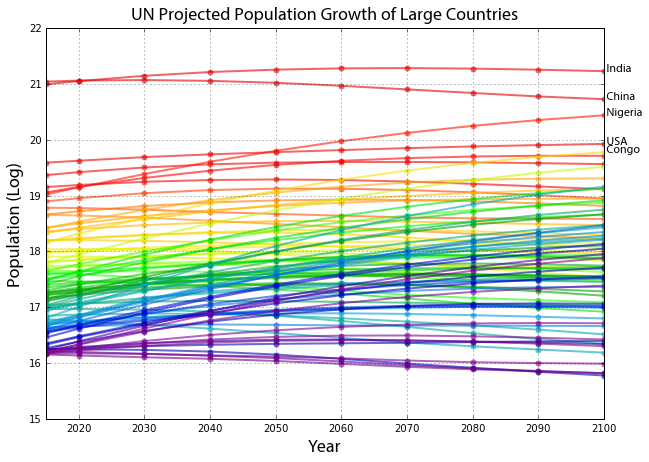

In [21]:
# plot again, this time with the log values
fig, ax = plt.subplots(figsize=[10, 7])
for col, c in reversed(zip(df_log_plot.columns, color_list)):
    ax.plot(df_log_plot[col], linewidth=2, alpha=0.6, marker='o', markeredgewidth=0, color=c)
    
ax.set_title('UN Projected Population Growth of Large Countries', fontproperties=label_font, y=1.01)
ax.set_xlabel('Year', fontproperties=label_font)
ax.set_ylabel('Population (Log)', fontproperties=label_font)
ax.grid()
ax.set_axis_bgcolor('#ffffff')
ax.set_xlim([2015, 2100])

# annotate the top 5 countries
def annotate(row):
    bbox = dict(boxstyle='round', color='w', fc='w', alpha=0.0)
    name = ' {}'.format(row['country_name'])
    pop = np.log(int(row['2100']))
    ax.annotate(name, xy=(2100, pop), bbox=bbox, xycoords='data', fontproperties=annot_font)
df['country_name'] = df['country_name'].str.replace('United States of America', 'USA')
df['country_name'] = df['country_name'].str.replace('Democratic Republic of the Congo', 'Congo')
df.sort_values(by='2100', ascending=False).head().apply(annotate, axis=1)

fig.savefig('images/projected-pop-log-line.png', dpi=96)
plt.show()

## Now, visualize population change with a choropleth map

In [22]:
# calculate each country's percent change between 2015 and 2100
df['change'] = df['2100'] / df['2015']

In [23]:
# divide up the dataset into quantiles by population change
num_bins = 7
bin_labels = range(num_bins)
df['bin'] = pd.qcut(x=df['change'], q=num_bins, labels=bin_labels)

In [24]:
# create labels and ticks for the legend
def get_label(value):
    pct = int((value - 1) * 100)
    sign = '+' if pct > 0 else ''
    return '{}{:,}%'.format(sign, pct)

# the labels will be the mins of each bin and the max of the last bin
labels = [get_label(df[df['bin']==b]['change'].min()) for b in range(num_bins)]
labels.append(get_label(df[df['bin']==b]['change'].max()))
print labels

# add one more tick mark, for the max of the last bin
label_ticks = bin_labels + [num_bins]
print label_ticks

['-54%', '-27%', '-5%', '+14%', '+34%', '+66%', '+198%', '+951%']
[0, 1, 2, 3, 4, 5, 6, 7]


In [25]:
# define map colors
cholorpleth_color_map = 'viridis'
water_color = '#dddddd'
border_color = '#ffffff'
no_data_color = '#ffffff'
map_boundary_color = '#999999'

In [26]:
# get a list of colors for our choropleth map
color_list = get_colors(cholorpleth_color_map, n=num_bins, start=0.0, stop=0.92, alpha=0.75)

C:\Anaconda\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


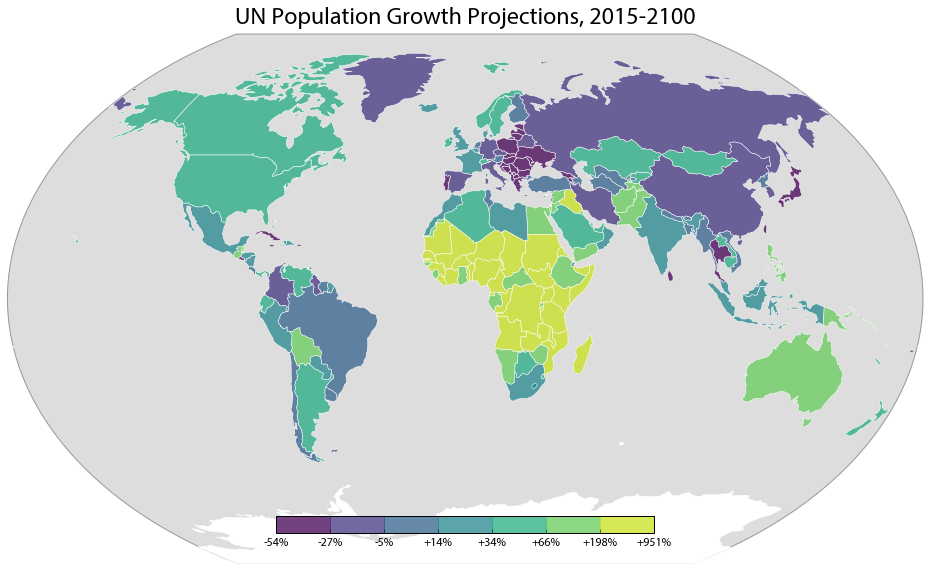

In [27]:
# now create the map: first set up the plotting figure
shapefile = 'data/countries_110m/ne_110m_admin_0_countries'
fig = plt.figure(figsize=[14, 8])
ax = fig.add_subplot(111, axisbg=water_color, frame_on=False)
ax.set_title('UN Population Growth Projections, 2015-2100', fontproperties=title_font, y=1.01)

# draw the basemap and read the shapefile
m = Basemap(lon_0=0, projection='kav7', resolution=None)
m.drawmapboundary(color=map_boundary_color)
m.readshapefile(shapefile, name='shapes', drawbounds=False)

# draw each shape, colored according to country's bin
for info, shape in zip(m.shapes_info, m.shapes):
    country_code = info['iso_n3']    
    if country_code in df['country_code'].values:
        bin_num = df[df['country_code']==country_code]['bin'].iloc[0]
        color = color_list[bin_num]
    else:
        color = no_data_color #if no data
    pc = PatchCollection([Polygon(np.array(shape), True)])
    pc.set_facecolor(color)
    pc.set_edgecolor(border_color)
    pc.set_linewidth(0.5)
    ax.add_collection(pc)

# draw color legend (lengths are ratios of figure size)
legend_width = 0.375
legend_left = (1 - legend_width) / 2.
legend_bottom = 0.07
legend_height = 0.03
legend_axis = fig.add_axes([legend_left, legend_bottom, legend_width, legend_height], zorder=2)
cmap = colors.ListedColormap(color_list)
cb = colorbar.ColorbarBase(legend_axis, cmap=cmap, ticks=label_ticks, boundaries=label_ticks, orientation='horizontal')
cb.ax.set_xticklabels(labels, fontproperties=annot_font)

fig.tight_layout()
fig.savefig('images/projected-pop-map.png', dpi=96)
plt.show()

## Lastly, show some descriptive tables

In [28]:
africa_change = africa['2100'] - africa['2015']
world_change = df['2100'] - df['2015']

print 'African population will grow by {:,.0f} people by 2100'.format(africa_change.sum())
print 'World population will grow by {:,.0f} people by 2100'.format(world_change.sum())
print 'That is {:,.0f} new people outside of Africa'.format(world_change.sum() - africa_change.sum())
print 'Africa accounts for {:,.1f}% of the projected growth'.format(africa_change.sum() * 100 / world_change.sum())

African population will grow by 3,200,412,787 people by 2100
World population will grow by 3,863,845,383 people by 2100
That is 663,432,596 new people outside of Africa
Africa accounts for 82.8% of the projected growth


In [29]:
# format populations and changes nicely for display
def get_pct_str(value):
    pct = (value - 1) * 100
    sign = '+' if pct > 0 else ''
    return '{}{:,.0f}%'.format(sign, pct)

def get_change_str(value):
    sign = '+' if value > 0 else ''
    return '{}{:,.0f}'.format(sign, value)

def get_pop_str(value):
    return '{:,.0f}'.format(value)

In [30]:
change = df[['country_name', '2015', '2100', 'change']].copy()
change['% Change'] = change['change'].map(get_pct_str)
change['Pop Change'] = (change['2100'] - change['2015']).map(get_change_str)
change[['2015', '2100']] = change[['2015', '2100']].applymap(get_pop_str)
change = change.rename(columns={'country_name':'Country', '2015':'2015 Pop', '2100':'2100 Pop'})

In [31]:
# show the 10 countries projecting the greatest % population decline
change = change.sort_values(by='change', inplace=False).reset_index()
change.index = change.index.map(lambda x: x + 1)
change[['Country', '2015 Pop', '2100 Pop', 'Pop Change', '% Change']].head(10)

,Country,2015 Pop,2100 Pop,Pop Change,% Change
1,Republic of Moldova,"4,068,897","1,855,779","-2,213,118",-54%
2,Bulgaria,"7,149,787","3,406,196","-3,743,591",-52%
3,Bosnia and Herzegovina,"3,810,416","1,919,196","-1,891,220",-50%
4,Northern Mariana Islands,"55,070","28,889","-26,181",-48%
5,Taiwan,"23,381,038","12,518,164","-10,862,874",-46%
6,Romania,"19,511,324","10,700,428","-8,810,896",-45%
7,Poland,"38,611,794","22,288,717","-16,323,077",-42%
8,Ukraine,"44,823,765","26,400,264","-18,423,501",-41%
9,Armenia,"3,017,712","1,793,392","-1,224,320",-41%
10,Puerto Rico,"3,683,238","2,212,136","-1,471,102",-40%


In [32]:
# show the 10 countries projecting the greatest % population increase
change = change.sort_values(by='change', ascending=False, inplace=False).reset_index()
change.index = change.index.map(lambda x: x + 1)
change[['Country', '2015 Pop', '2100 Pop', 'Pop Change', '% Change']].head(10)

,Country,2015 Pop,2100 Pop,Pop Change,% Change
1,Niger,"19,899,120","209,334,454","+189,435,334",+952%
2,Zambia,"16,211,767","104,868,893","+88,657,126",+547%
3,Burundi,"11,178,921","62,661,944","+51,483,023",+461%
4,Tanzania,"53,470,420","299,132,889","+245,662,469",+459%
5,Angola,"25,021,974","138,737,554","+113,715,580",+454%
6,Somalia,"10,787,104","58,310,946","+47,523,842",+441%
7,Mali,"17,599,694","92,980,533","+75,380,839",+428%
8,Uganda,"39,032,383","202,867,655","+163,835,272",+420%
9,Malawi,"17,215,232","87,055,526","+69,840,294",+406%
10,Congo,"77,266,814","388,732,857","+311,466,043",+403%


In [33]:
# show the most populous countries in 2015
most_populous_2015 = df.sort_values(by='2015', ascending=False).reset_index().copy()
most_populous_2015.index = most_populous_2015.index.map(lambda x: x + 1)
most_populous_2015['2015'] = most_populous_2015['2015'].map(lambda x: '{:,.0f}'.format(x))
most_populous_2015 = most_populous_2015.rename(columns={'country_name':'Country', '2015':'2015 Pop'})
most_populous_2015[['Country', '2015 Pop']].head(10)

,Country,2015 Pop
1,China,"1,376,048,943"
2,India,"1,311,050,527"
3,USA,"321,773,631"
4,Indonesia,"257,563,815"
5,Brazil,"207,847,528"
6,Pakistan,"188,924,874"
7,Nigeria,"182,201,962"
8,Bangladesh,"160,995,642"
9,Russia,"143,456,918"
10,Mexico,"127,017,224"


In [34]:
# show the most populous countries in 2100
most_populous_2100 = df.sort_values(by='2100', ascending=False).reset_index().copy()
most_populous_2100.index = most_populous_2100.index.map(lambda x: x + 1)
most_populous_2100['2100'] = most_populous_2100['2100'].map(lambda x: '{:,.0f}'.format(x))
most_populous_2100 = most_populous_2100.rename(columns={'country_name':'Country', '2100':'2100 Pop'})
most_populous_2100[['Country', '2100 Pop']].head(10)

,Country,2100 Pop
1,India,"1,659,785,948"
2,China,"1,004,391,965"
3,Nigeria,"752,247,359"
4,USA,"450,384,823"
5,Congo,"388,732,857"
6,Pakistan,"364,282,652"
7,Indonesia,"313,648,122"
8,Tanzania,"299,132,889"
9,Ethiopia,"242,644,125"
10,Niger,"209,334,454"


In [35]:
# lastly, make a table for the regions
regions_change = df_regions[['country_name', '2015', '2100']].copy()
regions_change['change'] = regions_change['2100'] / regions_change['2015']
regions_change['pop_change'] = regions_change['2100'] - regions_change['2015']

regions_change['% Change'] = regions_change['change'].map(get_pct_str)
regions_change['Pop Change'] = regions_change['pop_change'].map(get_change_str)
regions_change = regions_change.sort_values(by='pop_change', inplace=False, ascending=False).reset_index()

regions_change.index = regions_change.index.map(lambda x: x + 1)
regions_change[['2015', '2100']] = regions_change[['2015', '2100']].applymap(get_pop_str)
regions_change = regions_change.rename(columns={'country_name':'Region', '2015':'2015 Pop', '2100':'2100 Pop'})
regions_change[['Region', '2015 Pop', '2100 Pop', 'Pop Change', '% Change']]

,Region,2015 Pop,2100 Pop,Pop Change,% Change
1,Africa,"1,186,178,282","4,386,591,069","+3,200,412,787",+270%
2,Asia,"4,393,296,014","4,888,652,982","+495,356,968",+11%
3,Northern America,"357,838,036","500,143,198","+142,305,162",+40%
4,Latin America,"634,386,567","721,224,187","+86,837,620",+14%
5,Oceania,"39,331,130","71,128,695","+31,797,565",+81%
6,Europe,"738,442,070","645,577,351","-92,864,719",-13%
